# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Layer
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import Adam
import tensorflow_model_optimization as tfmot

from scipy.stats import percentileofscore
import time
import math

# Training data

In [2]:
df = pd.read_parquet('poz-w-dataset-grid.parquet')
#df = pd.read_parquet('poz-w-dataset.parquet')
df.head(5)

,from_x,from_y,to_x,to_y,day_type,start,time
0,-6753.15625,10778.15625,2727.515869,135.041199,2,66374,9115
1,2145.96875,4846.15625,4691.691406,3308.821289,1,73945,2292
2,11030.46875,-11807.50000,2723.373535,2488.457764,2,70073,7887
3,-3430.78125,-2428.37500,2339.359375,-1974.487549,0,50317,3194
4,9811.06250,-18968.84375,-2723.906982,1556.777344,1,40187,8026


In [3]:
print(df.size)

14000000


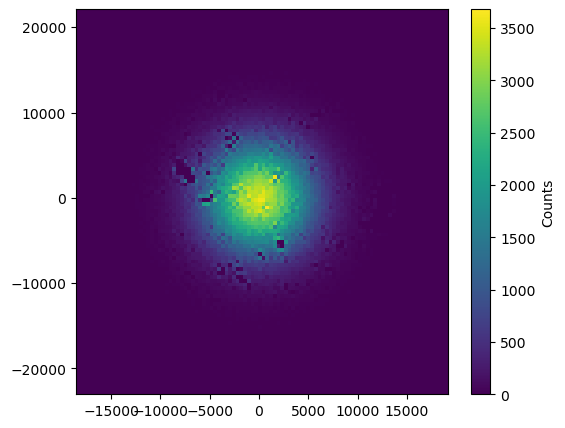

In [4]:
x = df['to_x']
y = df['to_y']

plt.figure(figsize=(6, 5))
plt.hist2d(x, y, bins=100, cmap='viridis')

plt.colorbar(label='Counts')

In [5]:
X = df[['from_x', 'from_y', 'to_x', 'to_y', 'day_type', 'start']]
y = df['time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Preprocessing

In [6]:
class CustomScalerLayer(Layer):
    def __init__(self, city_diameter=25000, **kwargs):
        super(CustomScalerLayer, self).__init__(**kwargs)
        self.city_diameter = city_diameter

    def call(self, inputs):
        # Normalize coordinates
        from_x = (inputs[:, 0] / self.city_diameter) + 0.5
        from_y = (inputs[:, 1] / self.city_diameter) + 0.5
        to_x = (inputs[:, 2] / self.city_diameter) + 0.5
        to_y = (inputs[:, 3] / self.city_diameter) + 0.5
        
        # Normalize start time
        start = inputs[:, 5] / 86400.0  # 86400 seconds in a day
        
        # Combine normalized features
        normalized_inputs = tf.stack([from_x, from_y, to_x, to_y, inputs[:, 4], start], axis=1)
        return normalized_inputs
    
    def get_config(self):
        config = super(CustomScalerLayer, self).get_config()
        config.update({
            "city_diameter": self.city_diameter,
        })
        return config
    
class CustomScalerLayerQuantizeConfig(tfmot.quantization.keras.QuantizeConfig):
    def get_weights_and_quantizers(self, layer):
        return []

    def get_activations_and_quantizers(self, layer):
        return []

    def set_quantize_weights(self, layer, quantize_weights):
        pass

    def set_quantize_activations(self, layer, quantize_activations):
        pass

    def get_output_quantizers(self, layer):
        return [tfmot.quantization.keras.quantizers.MovingAverageQuantizer(
            num_bits=8, per_axis=False, symmetric=False, narrow_range=False)]

    def get_config(self):
        return {}

In [7]:
scaler_layer = CustomScalerLayer()

# Model definition

## architecture

In [8]:
model = Sequential([
    
#    tfmot.quantization.keras.quantize_annotate_layer(
 #       CustomScalerLayer(city_diameter=25000),
  #      quantize_config=CustomScalerLayerQuantizeConfig()
   # ),
    Dense(64, activation='relu', kernel_initializer=HeNormal(),input_shape=(X_train.shape[1],)),
    #Dense(64, activation='relu', kernel_initializer=HeNormal()),
    Dense(128, activation='relu', kernel_initializer=HeNormal()),
    #Dense(256, activation='relu', kernel_initializer=HeNormal()),
    Dense(128, activation='relu', kernel_initializer=HeNormal()),
    Dense(64, activation='relu', kernel_initializer=HeNormal()),
    Dense(16, activation='relu', kernel_initializer=HeNormal()),
    Dense(4, activation='relu', kernel_initializer=HeNormal()),
    Dense(1, activation='exponential')
    #Dense(1, activation='softplus')
])

In [9]:
def scheduler(epoch, lr):
    if epoch < 2:
        return lr * 0.1
    else:
        return lr

In [10]:
class BatchLearningRateScheduler(Callback):
    def __init__(self, total_batches):
        super(BatchLearningRateScheduler, self).__init__()
        self.total_batches = total_batches
        self.current_epoch = 0

    def on_epoch_begin(self, epoch, logs=None):
        self.current_epoch = epoch

    def on_batch_begin(self, batch, logs=None):
        if self.current_epoch == 0 and batch < self.total_batches:
            lr = tf.keras.backend.get_value(self.model.optimizer.lr)
            ratio = (batch + 1) / self.total_batches
            divisor = ratio if ratio > 0.1 else 0.1
            new_lr = lr * divisor
            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
        elif self.current_epoch > 0:
            lr = tf.keras.backend.get_value(self.model.optimizer.lr)
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)

In [11]:
total_batches = 3000
batch_lr_scheduler = BatchLearningRateScheduler(total_batches)
simple_lr_scheduler = LearningRateScheduler(scheduler)

## loss function

In [12]:
def quadrtic(ratio):
    return (1-ratio)**2

def squized_sigmoid(ratio):
    return 1/(1 + tf.math.exp(-30*(ratio-1)))

In [13]:
def asymetric_loss_function(y_true, y_pred):
    #y_true = tf.cast(y_true, tf.float32)
    #y_pred = tf.cast(y_pred, tf.float32)
    
    #tf.print("y_true:", y_true, summarize=-1)
    #tf.print("y_pred:", y_pred, summarize=-1)

    tf.debugging.assert_all_finite(y_pred, "y_pred contains NaN values!")
    
    tf.debugging.assert_greater_equal(
        tf.reduce_min(y_pred), tf.constant(0.0, dtype=tf.float32),
        message=f"y_pred contains negative values! {y_pred}"
    )

    ratio = y_pred / y_true
    
    tf.debugging.assert_non_negative(
        ratio,
        message="Ratio is negative!"
    )
    sigmoid = squized_sigmoid(ratio)
    loss = quadrtic(ratio)*(1-sigmoid)+3*ratio*sigmoid

    return tf.reduce_mean(loss)

## compile

In [14]:
model.build(input_shape=(None, X_train.shape[1]))
#model.compile(optimizer='adam', loss=asymetric_loss_function, metrics=['mape'])

In [15]:
#with tfmot.quantization.keras.quantize_scope({
 #   'CustomScalerLayer': CustomScalerLayer,
  #  'CustomScalerLayerQuantizeConfig': CustomScalerLayerQuantizeConfig
#}):
quantize_model = tfmot.quantization.keras.quantize_model
qat_model = quantize_model(model)

ValueError: Only some Keras activations under `keras.activations` are supported. For other activations, use `Quantizer` directly, and update layer config using `QuantizeConfig`.

In [ ]:
qat_model.compile(optimizer='adam', loss=asymetric_loss_function, metrics=['mape'])

# Training

In [ ]:
history = qat_model.fit(X_train, y_train, epochs=8, batch_size=16, validation_split=0.2)

Epoch 1/8
80000/80000 [==============================] - 160s 2ms/step - loss: 0.3267 - mape: 48.1184 - val_loss: 0.2476 - val_mape: 45.2678
Epoch 2/8
74414/80000 [==========================>...] - ETA: 11s - loss: 0.2454 - mape: 41.6295

KeyboardInterrupt: 

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
"""
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # Enable TensorFlow Select ops.
]
"""
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpk41yya1a\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpk41yya1a\assets


## Quantization

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(qat_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()
with open('quantized_model.tflite', 'wb') as f:
    f.write(quantized_tflite_model)

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp82x8py8j\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp82x8py8j\assets
c:\Users\User\anaconda3\envs\BSC-thesis-deep-learning\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


# Model evaluation

## Read tflite model

In [ ]:
with open('model.tflite', 'rb') as f:
    tflite_model = f.read()

interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

## predicitons on test set

In [ ]:
y_pred = []

for i in range(X_test.shape[0]):
    single_row = X_test.iloc[i].to_numpy().reshape(1, -1).astype(np.float32)
    #single_row = X_test.iloc[i].to_numpy().reshape(1, -1).astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], single_row)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    y_pred.append(output_data[0][0])

y_pred = np.array(y_pred)

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Absolute Percentage Error (MAPE): 0.35%


## Visualize set results distribution

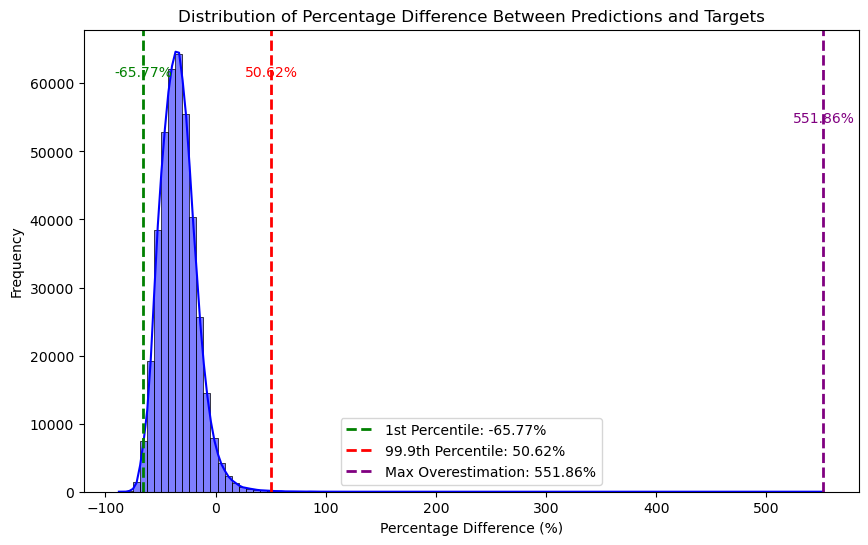

Maximal Overestimation Value: 551.86%
Percentile for 0 on x-axis value: 97.07%


In [ ]:
percentage_difference = ((y_pred - y_test) / y_test) * 100

percentile_1 = np.percentile(percentage_difference, 1)
percentile_99 = np.percentile(percentage_difference, 99.9)
max_overestimation = np.max(percentage_difference)
percentile_of_0 = percentileofscore(percentage_difference, 0)

plt.figure(figsize=(10, 6))
sns.histplot(percentage_difference, kde=True, bins=100, color='blue')

plt.axvline(percentile_1, color='green', linestyle='--', linewidth=2, label=f'1st Percentile: {percentile_1:.2f}%')
plt.axvline(percentile_99, color='red', linestyle='--', linewidth=2, label=f'99.9th Percentile: {percentile_99:.2f}%')

plt.text(percentile_1, plt.ylim()[1] * 0.9, f'{percentile_1:.2f}%', color='green', ha='center')
plt.text(percentile_99, plt.ylim()[1] * 0.9, f'{percentile_99:.2f}%', color='red', ha='center')

plt.axvline(max_overestimation, color='purple', linestyle='--', linewidth=2, label=f'Max Overestimation: {max_overestimation:.2f}%')
plt.text(max_overestimation, plt.ylim()[1] * 0.8, f'{max_overestimation:.2f}%', color='purple', ha='center')

plt.xlabel('Percentage Difference (%)')
plt.ylabel('Frequency')
plt.title('Distribution of Percentage Difference Between Predictions and Targets')
plt.legend()
plt.show()

print(f'Maximal Overestimation Value: {max_overestimation:.2f}%')
print(f'Percentile for 0 on x-axis value: {percentile_of_0:.2f}%')

## Forward pass time

In [ ]:
num_iterations = 10000
total_time = 0

for _ in range(num_iterations):
    random_index = np.random.randint(0, X_test.shape[0])
    single_row = X_test.iloc[i].to_numpy().reshape(1, -1).astype(np.float32)
    #single_row = X_test.iloc[i].to_numpy().reshape(1, -1).astype(np.float32)
    start_time = time.perf_counter()
    interpreter.set_tensor(input_details[0]['index'], single_row)
    interpreter.invoke()
    
    output_data = interpreter.get_tensor(output_details[0]['index'])
    end_time = time.perf_counter()
    total_time += (end_time - start_time)

average_forward_pass_time = (total_time / num_iterations) * 1e6
print(f"Average forward pass time for a single row using TensorFlow Lite: {average_forward_pass_time:.6f} microseconds")
print(f"total time for 10000 rows: {total_time*1000} milliseconds")

Average forward pass time for a single row using TensorFlow Lite: 9.256320 microseconds
total time for 10000 rows: 92.56320056738332 milliseconds
